In [1]:
# !pip install opencv-python

In [97]:
!pip install --upgrade pandas

     |████████████████████████████████| 11.7 MB 17.9 MB/s eta 0:00:01     |████████████████████████████▎   | 10.3 MB 17.9 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.5
    Uninstalling pandas-1.2.5:
      Successfully uninstalled pandas-1.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dtreeviz 1.3.2 requires colour, which is not installed.
dtreeviz 1.3.2 requires graphviz>=0.9, which is not installed.
dtreeviz 1.3.2 requires pytest, which is not installed.


In [98]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from pathlib import Path

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import PIL
from PIL import Image
import pickle
import random
import gc
import cv2

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import keras_cv_attention_models

## Preparing the Dataset and Setting Parameters

In [3]:
seed = 143
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

In [4]:
data_dir = './raw/'
save_dir = './savefiles/'
size = 64
epochs = 30
val_split = 0.25

batch_size = 32

data_path = Path(data_dir)
images = sorted(list(map(str, list(data_path.glob("*/*.jpg")))))
labels = set([img.split(os.path.sep)[-2] for img in images])
num_labels = len(labels)

steps_per_epoch = len(images) * (1 - val_split) / batch_size
validation_steps = len(images) * val_split / batch_size

print("Number of images found: ", len(images))
print("Number of labels found: ", num_labels)
print("Labels:", sorted(labels))

Number of images found:  38398
Number of labels found:  19
Labels: ['a', 'ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'kuw', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'tul', 'wa', 'ya']


In [5]:
label_dict = {i: j for i, j in zip(range(19), sorted(labels))}
label_dict

{0: 'a',
 1: 'ba',
 2: 'dara',
 3: 'ei',
 4: 'ga',
 5: 'ha',
 6: 'ka',
 7: 'kuw',
 8: 'la',
 9: 'ma',
 10: 'na',
 11: 'nga',
 12: 'ou',
 13: 'pa',
 14: 'sa',
 15: 'ta',
 16: 'tul',
 17: 'wa',
 18: 'ya'}

In [6]:
dist = pd.Series([img.split(os.path.sep)[-2] for img in images]).value_counts()
PCC = sum(pd.Series([img.split(os.path.sep)[-2] for img in images]).
       value_counts(normalize=True)**2)

display(dist.sort_index())
print(f'PCC x 1.25: = {1.25*PCC:.3%}')

a       1307
ba      2088
dara    2410
ei      1294
ga      2479
ha      2397
ka      2564
kuw     1091
la      2284
ma      2185
na      2365
nga     2378
ou      1287
pa      2255
sa      2155
ta      2302
tul     1000
wa      2308
ya      2249
dtype: int64

PCC x 1.25: = 6.996%


ᜅ

In [15]:
dist.sum()

38398

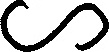

In [21]:
im = Image.open(data_dir + 'ha/ha_00001_file001.jpg')
im.show()

/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():


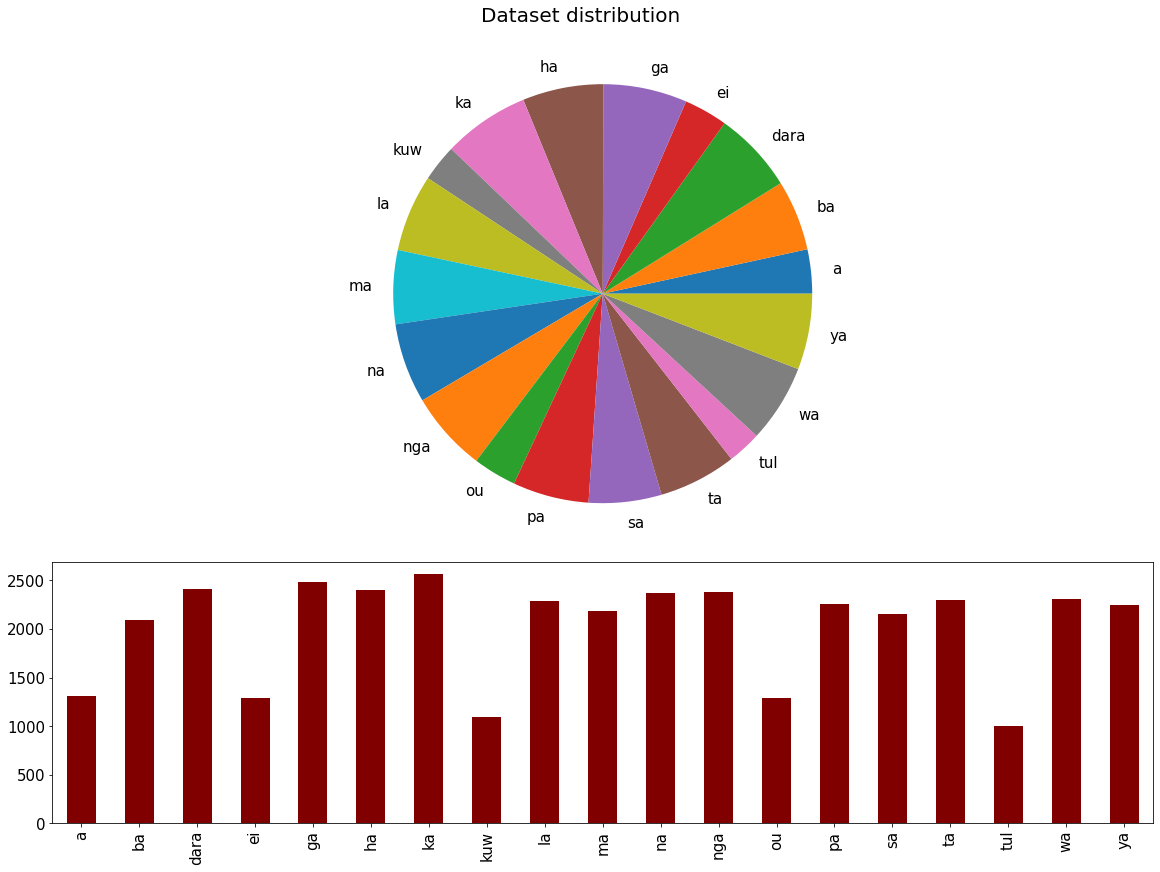

In [126]:
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = fig.add_gridspec(3, 1)

ax1 = fig.add_subplot(gs[0:2])
ax1 = dist.sort_index().plot(kind='pie', fontsize=15)
ax1.set_ylabel('')

ax2 = fig.add_subplot(gs[2])
dist.sort_index().plot(kind='bar', color='maroon', fontsize=15)
# ax2.bar(dist.sort_index().index, dist.sort_index(), color='maroon')

plt.suptitle('Dataset distribution', fontsize=20)

plt.show()


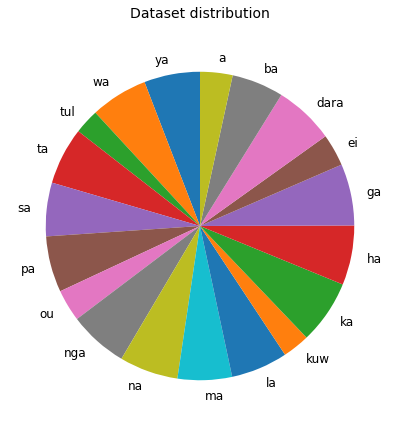

In [137]:
fig, ax = plt.subplots(figsize=(6, 6))
dist.sort_index(ascending=False).plot(kind='pie', fontsize=12, startangle=90)
plt.ylabel('')
plt.suptitle('Dataset distribution', fontsize=14)
plt.tight_layout()
plt.show()

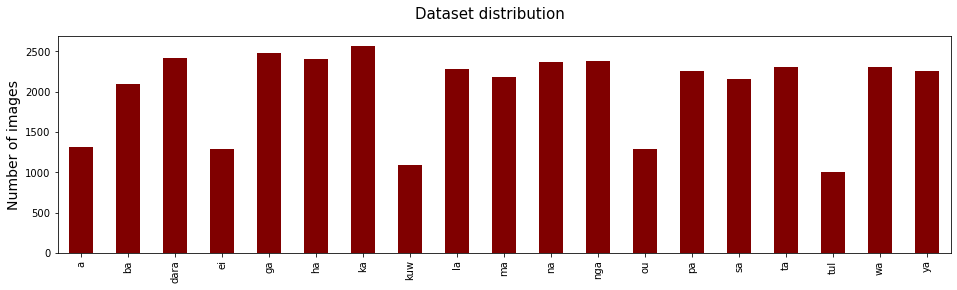

In [141]:
fig, ax = plt.subplots(figsize=(16, 4))
dist.sort_index().plot(kind='bar', color='maroon')
plt.ylabel('Number of images', fontsize=14)
plt.suptitle('Dataset distribution', fontsize=15)
plt.show()

In [5]:
# !ls raw

In [6]:
# Check dimensions of a sample image

# img = cv2.imread(data_dir + 'a/a_00553_file087.jpg')
# dimensions = img.shape
# dimensions

In [22]:
# Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=val_split)


# Load data and turn into batches
train_data = train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

val_data = val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


In [23]:
# For Keras Models (VGG16, Inception)

keras_train_datagen = ImageDataGenerator(validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

keras_val_datagen = ImageDataGenerator(validation_split=val_split)


# Load data and turn into batches
keras_train_data = keras_train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

keras_val_data = keras_val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


In [24]:
len(set(train_data.labels))

19

## Models

### CNN

In [63]:
tf.keras.backend.clear_session()
gc.collect()

16849

In [64]:
base_cnn = models.Sequential()

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                 input_shape=(size, size, 3)))
base_cnn.add(layers.BatchNormalization(axis=3))
base_cnn.add(layers.Activation('relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                        activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(3, 3)))

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(32, activation="relu"))
base_cnn.add(layers.Dropout(0.6))

base_cnn.add(layers.Dense(num_labels, activation='softmax'))
base_cnn.summary()


base_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 4)         112       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 4)         16        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [65]:
%%time

filepath_cnn = save_dir + "/base_cnn_wts.hdf5"
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.00001, verbose=1)
earlystop_cnn = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


base_cnn_history = base_cnn.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_data,
    callbacks=[checkpoint_cnn, reduce_lr_cnn, earlystop_cnn]
)

Epoch 1/30
899/899 [==============================] - 117s 130ms/step - loss: 2.6534 - accuracy: 0.1702 - val_loss: 1.4708 - val_accuracy: 0.6272

Epoch 00001: val_accuracy improved from -inf to 0.62719, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 2/30
899/899 [==============================] - 117s 130ms/step - loss: 2.1704 - accuracy: 0.3105 - val_loss: 1.0643 - val_accuracy: 0.7681

Epoch 00002: val_accuracy improved from 0.62719 to 0.76814, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 3/30
899/899 [==============================] - 117s 130ms/step - loss: 1.9710 - accuracy: 0.3675 - val_loss: 0.8629 - val_accuracy: 0.7809

Epoch 00003: val_accuracy improved from 0.76814 to 0.78086, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 4/30
899/899 [==============================] - 113s 126ms/step - loss: 1.8641 - accuracy: 0.3997 - val_loss: 0.8034 - val_accuracy: 0.7837

Epoch 00004: val_accuracy improved from 0.78086 to 0.78367, saving model to ./savefiles/base_cnn_

In [42]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

In [67]:
base_cnn.load_weights(filepath_cnn)

base_cnn.save(save_dir + '/base_cnn.h5')

import pickle
with open(save_dir + '/base_cnn_hist.pickle', 'wb') as handle:
    pickle.dump(base_cnn_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

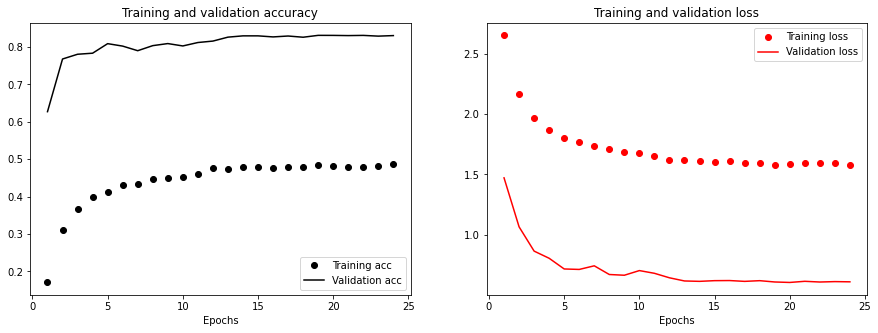

In [68]:
plot_results(base_cnn_history)

### VGG16

In [18]:
tf.keras.backend.clear_session()
gc.collect()

23728

In [19]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

vgg16 = tf.keras.applications.VGG16(weights=None,
                  include_top=False)

model_vgg16 = models.Sequential()
model_vgg16.add(layers.Lambda(preprocess_vgg16,
                             input_shape=(size, size, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(num_labels, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                38931     
Total params: 14,753,619
Trainable params: 14,753,619
Non-trainable params: 0
_________________________________________________________________


In [52]:
%%time

filepath_vgg = save_dir + "/base_vgg_wts.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_vgg = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_vgg = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


vgg_history = model_vgg16.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_vgg, reduce_lr_vgg, earlystop_vgg]
)

Epoch 1/30
899/899 [==============================] - 119s 131ms/step - loss: 0.7331 - accuracy: 0.7733 - val_loss: 0.3934 - val_accuracy: 0.9021

Epoch 00001: val_accuracy improved from -inf to 0.90211, saving model to ./savefiles/base_vgg_wts.hdf5
Epoch 2/30
899/899 [==============================] - 116s 129ms/step - loss: 0.1989 - accuracy: 0.9400 - val_loss: 0.1167 - val_accuracy: 0.9658

Epoch 00002: val_accuracy improved from 0.90211 to 0.96580, saving model to ./savefiles/base_vgg_wts.hdf5
Epoch 3/30
899/899 [==============================] - 140s 156ms/step - loss: 0.1496 - accuracy: 0.9560 - val_loss: 0.1804 - val_accuracy: 0.9441

Epoch 00003: val_accuracy did not improve from 0.96580
Epoch 4/30
899/899 [==============================] - 116s 128ms/step - loss: 0.1197 - accuracy: 0.9649 - val_loss: 0.1340 - val_accuracy: 0.9602

Epoch 00004: val_accuracy did not improve from 0.96580

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/30


In [54]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16.h5')

with open(save_dir + '/vgg16_hist.pickle', 'wb') as handle:
    pickle.dump(vgg_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

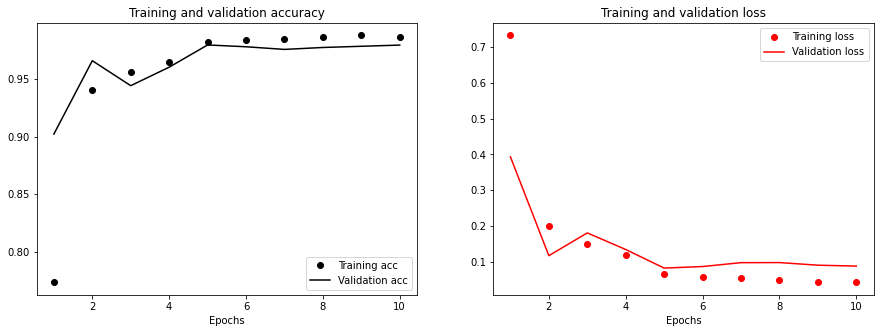

In [56]:
plot_results(vgg_history)

#### Tried VGG16 again

In [20]:
%%time

filepath_vgg = save_dir + "/base_vgg_wts_v2.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_vgg = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_vgg = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


vgg_history = model_vgg16.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_vgg, reduce_lr_vgg, earlystop_vgg]
)

Epoch 1/30
899/899 [==============================] - 121s 133ms/step - loss: 0.7419 - accuracy: 0.7682 - val_loss: 0.1836 - val_accuracy: 0.9461

Epoch 00001: val_accuracy improved from -inf to 0.94610, saving model to ./savefiles/base_vgg_wts_v2.hdf5
Epoch 2/30
899/899 [==============================] - 112s 125ms/step - loss: 0.1922 - accuracy: 0.9435 - val_loss: 0.1373 - val_accuracy: 0.9583

Epoch 00002: val_accuracy improved from 0.94610 to 0.95830, saving model to ./savefiles/base_vgg_wts_v2.hdf5
Epoch 3/30
899/899 [==============================] - 114s 127ms/step - loss: 0.1415 - accuracy: 0.9576 - val_loss: 0.1619 - val_accuracy: 0.9507

Epoch 00003: val_accuracy did not improve from 0.95830
Epoch 4/30
899/899 [==============================] - 113s 125ms/step - loss: 0.1217 - accuracy: 0.9640 - val_loss: 0.1345 - val_accuracy: 0.9577

Epoch 00004: val_accuracy did not improve from 0.95830
Epoch 5/30
899/899 [==============================] - 115s 127ms/step - loss: 0.1001 - 

In [21]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16_v2.h5')

with open(save_dir + '/vgg16_hist_v2.pickle', 'wb') as handle:
    pickle.dump(vgg_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

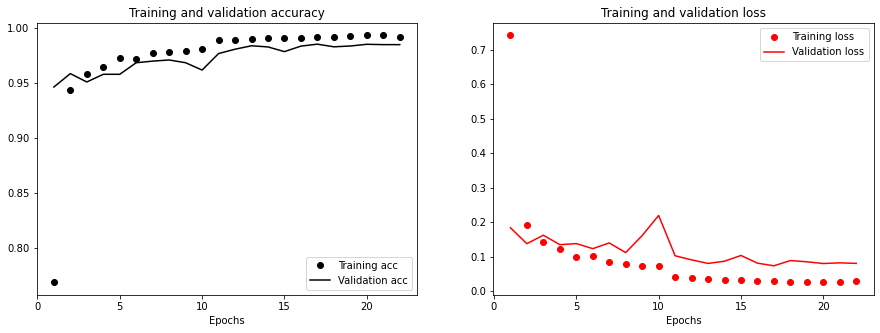

In [24]:
plot_results(vgg_history)

### ResNet50

In [34]:
tf.keras.backend.clear_session()
gc.collect()

33653

In [38]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_res50

resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None)

model_res50 = models.Sequential()

model_res50.add(layers.Lambda(preprocess_res50,
                             input_shape=(size, size, 3)))
model_res50.add(resnet50)
model_res50.add(layers.Flatten())
# model_res50.add(layers.Dense(32, activation="relu"))
# model_effb0.add(layers.Dropout(0.6))
model_res50.add(layers.Dense(num_labels, activation='softmax'))

model_res50.summary()

model_res50.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 19)                155667    
Total params: 23,743,379
Trainable params: 23,690,259
Non-trainable params: 53,120
_________________________________________________________________


In [39]:
%%time

filepath_res = save_dir + "/base_res_wts.hdf5"
checkpoint_res = ModelCheckpoint(filepath_res, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_res = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_res = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


res_history = model_res50.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_res, reduce_lr_res, earlystop_res]
)

Epoch 1/30
899/899 [==============================] - 123s 131ms/step - loss: 2.6374 - accuracy: 0.2764 - val_loss: 2.0328 - val_accuracy: 0.4513

Epoch 00001: val_accuracy improved from -inf to 0.45131, saving model to ./savefiles/base_res_wts.hdf5
Epoch 2/30
899/899 [==============================] - 115s 127ms/step - loss: 1.1996 - accuracy: 0.6260 - val_loss: 1.1956 - val_accuracy: 0.6686

Epoch 00002: val_accuracy improved from 0.45131 to 0.66858, saving model to ./savefiles/base_res_wts.hdf5
Epoch 3/30
899/899 [==============================] - 115s 127ms/step - loss: 0.7017 - accuracy: 0.7832 - val_loss: 0.7144 - val_accuracy: 0.8098

Epoch 00003: val_accuracy improved from 0.66858 to 0.80984, saving model to ./savefiles/base_res_wts.hdf5
Epoch 4/30
899/899 [==============================] - 110s 122ms/step - loss: 0.4655 - accuracy: 0.8600 - val_loss: 0.6326 - val_accuracy: 0.8337

Epoch 00004: val_accuracy improved from 0.80984 to 0.83372, saving model to ./savefiles/base_res_

In [41]:
model_res50.load_weights(filepath_res)

model_res50.save(save_dir + '/res50.h5')

with open(save_dir + '/res50_hist.pickle', 'wb') as handle:
    pickle.dump(res_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

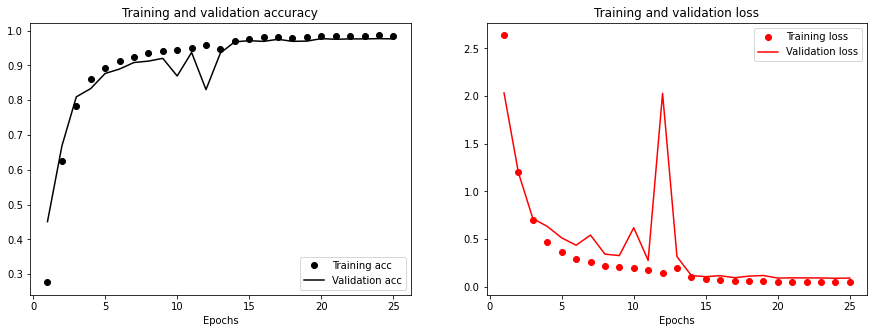

In [43]:
plot_results(res_history)

### EfficientNet

In [40]:
tf.keras.backend.clear_session()
gc.collect()

2857

In [44]:
effnetb0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=(size, size, 3))

model_effb0 = models.Sequential()

model_effb0.add(effnetb0)
model_effb0.add(layers.Flatten())
# model_effb0.add(layers.Dense(32, activation="relu"))
# model_effb0.add(layers.Dropout(0.6))
model_effb0.add(layers.Dense(num_labels, activation='softmax'))

model_effb0.summary()

model_effb0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                97299     
Total params: 4,146,870
Trainable params: 4,104,847
Non-trainable params: 42,023
_________________________________________________________________


In [45]:
%%time

filepath_eff = save_dir + "/base_eff_wts.hdf5"
checkpoint_eff = ModelCheckpoint(filepath_eff, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_eff = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_eff = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


eff_history = model_effb0.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_eff, reduce_lr_eff, earlystop_eff]
)

Epoch 1/30
899/899 [==============================] - 127s 130ms/step - loss: 2.9586 - accuracy: 0.1144 - val_loss: 7.9886 - val_accuracy: 0.1046

Epoch 00001: val_accuracy improved from -inf to 0.10457, saving model to ./savefiles/base_eff_wts.hdf5
Epoch 2/30
899/899 [==============================] - 110s 122ms/step - loss: 2.5397 - accuracy: 0.2229 - val_loss: 5.6488 - val_accuracy: 0.1860

Epoch 00002: val_accuracy improved from 0.10457 to 0.18599, saving model to ./savefiles/base_eff_wts.hdf5
Epoch 3/30
899/899 [==============================] - 112s 124ms/step - loss: 2.0065 - accuracy: 0.3571 - val_loss: 2.9666 - val_accuracy: 0.3832

Epoch 00003: val_accuracy improved from 0.18599 to 0.38324, saving model to ./savefiles/base_eff_wts.hdf5
Epoch 4/30
899/899 [==============================] - 113s 125ms/step - loss: 1.5145 - accuracy: 0.5040 - val_loss: 1.7189 - val_accuracy: 0.5303

Epoch 00004: val_accuracy improved from 0.38324 to 0.53034, saving model to ./savefiles/base_eff_

In [46]:
model_effb0.load_weights(filepath_eff)

model_effb0.save(save_dir + '/effb0.h5')

with open(save_dir + '/effb0_hist.pickle', 'wb') as handle:
    pickle.dump(eff_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

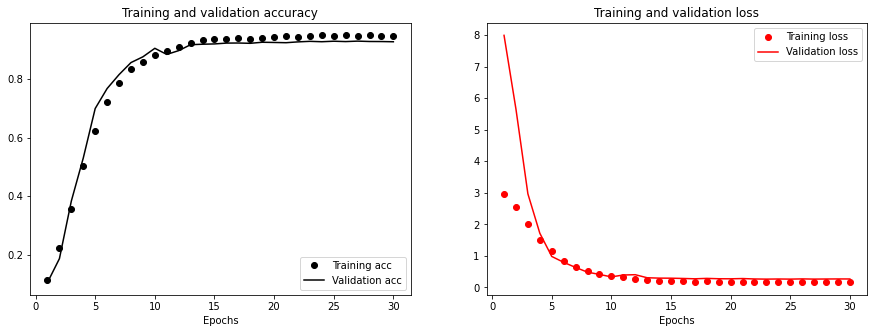

In [47]:
plot_results(eff_history)

### CoAtNet

In [83]:
tf.keras.backend.clear_session()
gc.collect()

In [84]:
coatnet0 = keras_cv_attention_models.coatnet.CoAtNet0(num_classes=0,
                                                      pretrained=None,
                                                      input_shape=(size, size, 3))

model_coat0 = models.Sequential()

model_coat0.add(coatnet0)
model_coat0.add(layers.Flatten())
# model_coat0.add(layers.Dense(32, activation="relu"))
# model_coat0.add(layers.Dropout(0.6))
model_coat0.add(layers.Dense(num_labels, activation='softmax'))

model_coat0.summary()

model_coat0.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 2, 2, 768)         23032698  
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                58387     
Total params: 23,091,085
Trainable params: 23,079,437
Non-trainable params: 11,648
_________________________________________________________________


In [73]:
%%time

filepath_coat = save_dir + "/base_coat_wts.hdf5"
checkpoint_coat = ModelCheckpoint(filepath_coat, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_coat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_coat= EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


coat_history = model_coat0.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_coat, reduce_lr_coat, earlystop_coat]
)

Epoch 1/30
899/899 [==============================] - 138s 138ms/step - loss: 2.1519 - accuracy: 0.6282 - val_loss: 0.9994 - val_accuracy: 0.8247

Epoch 00001: val_accuracy improved from -inf to 0.82475, saving model to ./savefiles/base_coat_wts.hdf5


/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
899/899 [==============================] - 119s 132ms/step - loss: 0.8063 - accuracy: 0.8394 - val_loss: 0.6910 - val_accuracy: 0.8637

Epoch 00002: val_accuracy improved from 0.82475 to 0.86374, saving model to ./savefiles/base_coat_wts.hdf5
Epoch 3/30
899/899 [==============================] - 117s 130ms/step - loss: 0.6343 - accuracy: 0.8824 - val_loss: 0.6891 - val_accuracy: 0.8864

Epoch 00003: val_accuracy improved from 0.86374 to 0.88636, saving model to ./savefiles/base_coat_wts.hdf5
Epoch 4/30
899/899 [==============================] - 116s 129ms/step - loss: 0.5349 - accuracy: 0.9031 - val_loss: 0.6355 - val_accuracy: 0.8984

Epoch 00004: val_accuracy improved from 0.88636 to 0.89835, saving model to ./savefiles/base_coat_wts.hdf5
Epoch 5/30
899/899 [==============================] - 116s 129ms/step - loss: 0.4747 - accuracy: 0.9162 - val_loss: 0.4197 - val_accuracy: 0.9281

Epoch 00005: val_accuracy improved from 0.89835 to 0.92807, saving model to ./savefiles/bas

In [74]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0.h5')

with open(save_dir + '/coat0_hist.pickle', 'wb') as handle:
    pickle.dump(coat_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

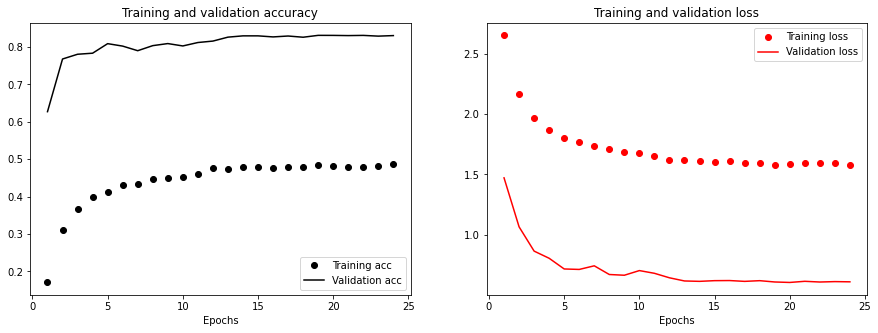

In [75]:
plot_results(base_cnn_history)

#### Tried CoAtNet again

In [85]:
%%time

filepath_coat = save_dir + "/base_coat_wts_v2.hdf5"
checkpoint_coat = ModelCheckpoint(filepath_coat, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_coat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_coat= EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


coat_history = model_coat0.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_data,
    callbacks=[checkpoint_coat, reduce_lr_coat, earlystop_coat]
)

Epoch 1/30
899/899 [==============================] - 173s 174ms/step - loss: 2.1017 - accuracy: 0.6296 - val_loss: 0.9069 - val_accuracy: 0.8177

Epoch 00001: val_accuracy improved from -inf to 0.81766, saving model to ./savefiles/base_coat_wts_v2.hdf5
Epoch 2/30
899/899 [==============================] - 122s 136ms/step - loss: 0.8194 - accuracy: 0.8392 - val_loss: 0.5237 - val_accuracy: 0.8968

Epoch 00002: val_accuracy improved from 0.81766 to 0.89679, saving model to ./savefiles/base_coat_wts_v2.hdf5
Epoch 3/30
899/899 [==============================] - 117s 130ms/step - loss: 0.6359 - accuracy: 0.8830 - val_loss: 0.5662 - val_accuracy: 0.9019

Epoch 00003: val_accuracy improved from 0.89679 to 0.90190, saving model to ./savefiles/base_coat_wts_v2.hdf5
Epoch 4/30
899/899 [==============================] - 120s 133ms/step - loss: 0.5360 - accuracy: 0.9048 - val_loss: 0.4588 - val_accuracy: 0.9212

Epoch 00004: val_accuracy improved from 0.90190 to 0.92118, saving model to ./savefil

In [86]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0_v2.h5')

with open(save_dir + '/coat0_hist_v2.pickle', 'wb') as handle:
    pickle.dump(coat_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

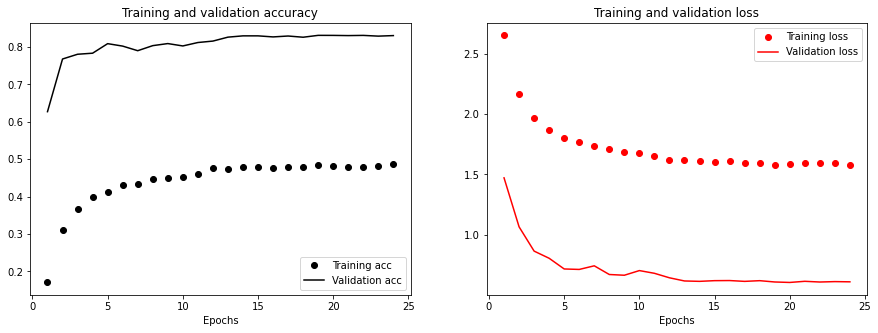

In [87]:
plot_results(base_cnn_history)

### LeViT192 (low accuracy)

In [52]:
tf.keras.backend.clear_session()
gc.collect()

24421

In [49]:
levit128 = keras_cv_attention_models.levit.LeViT128(
    num_classes=0,
    pretrained=None,
    input_shape=(size, size, 3))

# levit192.trainable = False

model_levit = models.Sequential()

model_levit.add(levit128)
model_levit.add(layers.Flatten())
# model_levit.add(layers.Dense(32, activation="relu"))
# model_levit.add(layers.Dropout(0.6))
model_levit.add(layers.Dense(num_labels, activation='softmax'))

model_levit.summary()

model_levit.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 1, 384)            8482272   
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 19)                7315      
Total params: 8,489,587
Trainable params: 8,442,515
Non-trainable params: 47,072
_________________________________________________________________


In [51]:
%%time

filepath_levit = save_dir + "/base_levit_wts.hdf5"
checkpoint_levit = ModelCheckpoint(filepath_levit, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_levit = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_levit= EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


levit_history = model_levit.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_data,
    callbacks=[checkpoint_levit, reduce_lr_levit, earlystop_levit]
)

In [ ]:
model_levit.load_weights(filepath_levit)

model_levit.save(save_dir + '/levit.h5')

with open(save_dir + '/levit_hist.pickle', 'wb') as handle:
    pickle.dump(levit_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Selection and Sample Prediction

Having trained the various models, it was a simple matter to compare the various test accuracies obtained. While all the architectures performed better than the baseline CNN model, it was clear that VGG16 had the best performance. Not only did it end up having the highest accuracy, but similar to ResNet50 and EfficientNetB0, its training plot was close to ideal as well, with no clear signs of overfitting or underfitting.

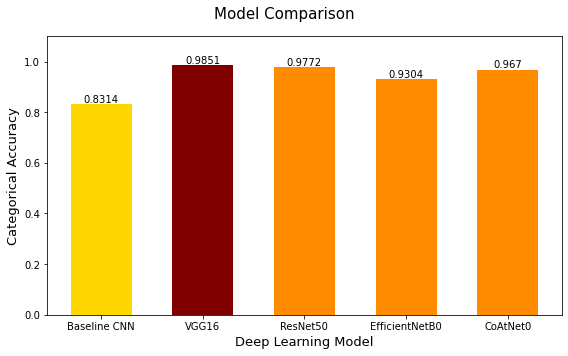

In [199]:
models = ['Baseline CNN', 'VGG16', 'ResNet50', 'EfficientNetB0', 'CoAtNet0']
scores = [.8314, .9851, .9772, .9304, .9675]
model_eval = pd.Series(scores, index=models)

fig, ax = plt.subplots(figsize=(8, 5))

pps = ax.bar(model_eval.index, model_eval.values, width=0.6,
             color=['gold', 'maroon', 'darkorange',
                    'darkorange', 'darkorange'])

for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 0), # vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.ylabel('Categorical Accuracy', fontsize=13)
plt.xlabel('Deep Learning Model', fontsize=13)
plt.suptitle('Model Comparison', fontsize=15)
plt.xticks(rotation='horizontal')
plt.tight_layout()
plt.show()

Given that VGG16 had the best performance, this was chosen as the preferred model for deployment. To demonstrate, it was used to predict the label of a sample image from the "a" vowel class. The VGG16 model was indeed able to classify the image correctly with a high degree of confidence.

Of course this is only a sanity check, as the sample image was taken from the original dataset and may not be considered as unseen data.

In [201]:
model = tf.keras.models.load_model(save_dir + 'vgg16_v2.h5')

Sample image:


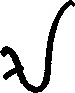

Predicted character: a
Prediction score: 99.7606%


In [203]:
img = cv2.imread(data_dir + 'a/a_00001_file001.jpg')
img = cv2.resize(img, (64, 64))
img = np.expand_dims(img, axis=0)

print('Sample image:')
im = Image.open(data_dir + 'a/a_00001_file001.jpg')
im.show()

predictions = model.predict(img)
pred_label = label_dict[np.argmax(predictions)]
probVal = np.amax(predictions)

print(f'Predicted character: {pred_label}')
print(f'Prediction score: {probVal:.4%}')

To deploy the model on new images, the team undertook to implement a real-time Optical Character Recognition Model, as demonstrated below. 

## Translating characters on video

### Note: Doesn't work in Jojie, has to be on local

In [100]:
# If using a video file:
video = './OpenCV/ka_pa.mp4'

# If using a webcam:
video = 0

In [ ]:
cap = cv2.VideoCapture(video)

if not cap.isOpened():
    print("Error loading the video file or camera")
    exit()

# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

width = 640
height = 480
cap.set(3, width)
cap.set(4, height)

time_start = time.time()


while True:
    try:
        success, imgOriginal = cap.read()
        img = cv2.resize(imgOriginal, (64, 64))
        img = np.expand_dims(img, axis=0)

        #predict
        predictions = model.predict(img)
        pred_label = label_dict[np.argmax(predictions)]
        probVal = np.amax(predictions)
        
        threshold = 0.50
        if probVal > threshold:
            cv2.putText(img=imgOriginal, text=pred_label + ': ' + str(probVal),
                        org=(100, 100), fontFace=cv2.FONT_HERSHEY_COMPLEX,
                        fontScale=3, color=(255,255,0), thickness=3)
            print(pred_label, probVal)
        else:
            cv2.putText(img=imgOriginal, text='Unable to predict',
                        org=(100, 100), fontFace=cv2.FONT_HERSHEY_COMPLEX,
                        fontScale=3, color=(255,255,0), thickness=3)
#             print(pred_label, probVal)

        cv2.imshow('Original Image', imgOriginal)

        time_now = time.time()
        num_seconds = time_now - time_start
        if num_seconds > 90:
            print('Time is up.')
            break

    except:
        print('Error: Closing camera')
        success = False
        cap.release()
        cv2.destroyAllWindows()
        break

    if (cv2.waitKey(1) & 0xFF == ord('q')):
        print('Camera or video closed by user')
        success = False
        cap.release()
        cv2.destroyAllWindows()
        break

    if not success:
        print('Failed to capture image')
        cap.release()
        cv2.destroyAllWindows()
        break


cap.release()
cv2.destroyAllWindows()
print('End of video')